# cGAN using pix2pix


## Importing the libraries

In [351]:
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
from PIL import Image
import numpy as np
tf.__version__

'2.10.0'

## Downloading the dataset

In [352]:
dataset = 'facades_b_w'



Other datasets:
* `cityscapes`
* `edges2handbags`
* `edges2shoes`
* `facades`
* `night2day`

(https://github.com/affinelayer/pix2pix-tensorflow#datasets-and-trained-models)

In [353]:
dataset_file = "facades.tar.gz".format(dataset)
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades"
print(dataset_url)
# dataset_file = "{}.tar.gz".format(dataset)
# dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(dataset_file)
# print(dataset_url)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades


In [354]:
download_zip = tf.keras.utils.get_file(fname = dataset_file, origin = dataset_url, extract = True)

In [355]:
download_zip = pathlib.Path(download_zip)
path = download_zip.parent/"facades"

In [356]:
path

WindowsPath('C:/Users/kashi/.keras/datasets/facades')

In [357]:
list(path.parent.iterdir())

[WindowsPath('C:/Users/kashi/.keras/datasets/facades'),
 WindowsPath('C:/Users/kashi/.keras/datasets/facades.tar.gz')]

In [358]:
sample = tf.io.read_file(str(path / 'train/3.jpg'))
sample = tf.io.decode_jpeg(sample)

(256, 512, 3)


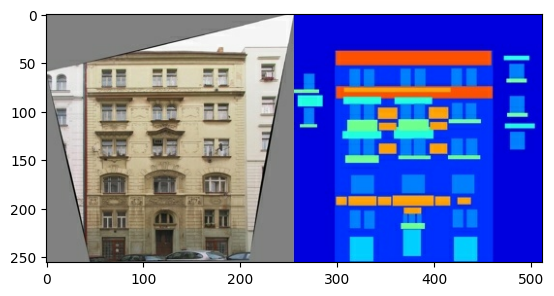

In [359]:
print(sample.shape)
plt.figure()
plt.imshow(sample);

## Functions to preprocessing

In [360]:
def rgb2gray(rgb):
    return tf.image.rgb_to_grayscale(rgb)


def invert_colors(img):
    return 255 - img


def blur_image(img, size=3):
    # Add a batch dimension to the image
    img = tf.expand_dims(img, axis=0)
    # Use average pooling to blur the image
    blurred_img = tf.nn.avg_pool2d(img, ksize=[1, size, size, 1], strides=[
                                   1, 1, 1, 1], padding='SAME')
    # Remove the batch dimension from the image
    blurred_img = tf.squeeze(blurred_img, axis=0)
    return blurred_img


def blend(original, mask):
    # Ensure that the original and mask images have the same shape
    mask = tf.image.resize(mask, tf.shape(original)[
                           0:2], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (original * (255 - mask) + (255 * mask)) / 255

In [361]:
def load_image(img_file):
    img = tf.io.read_file(img_file)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [256, 512])

    width = tf.shape(img)[1] // 2
    transformed_img = img[:, :width, :]
    original_img = img[:, width:, :]

    # Convert original image to grayscale
    original_gray = rgb2gray(original_img)

    # Invert the grayscale image
    inverted_img = invert_colors(original_gray)

    # Apply blurring to the inverted image
    blurred_img = blur_image(inverted_img)

    # Create pencil sketch by blending the original grayscale image with the inverted blurred image
    pencil_sketch = blend(original_gray, blurred_img)

    # Convert pencil_sketch to a 3-channel image
    pencil_sketch_3_channel = tf.image.grayscale_to_rgb(pencil_sketch)

    # Cast to float32
    transformed_img = tf.cast(transformed_img, tf.float32)
    pencil_sketch_3_channel = tf.cast(pencil_sketch_3_channel, tf.float32)

    return pencil_sketch_3_channel, transformed_img

(256, 256, 3) (256, 256, 3)


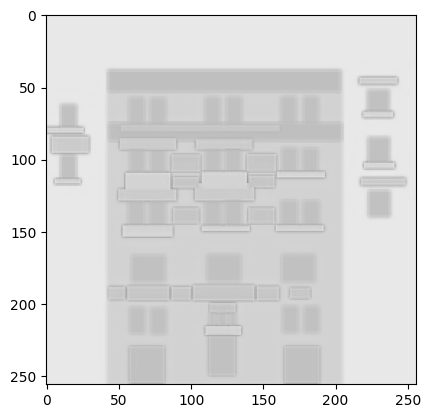

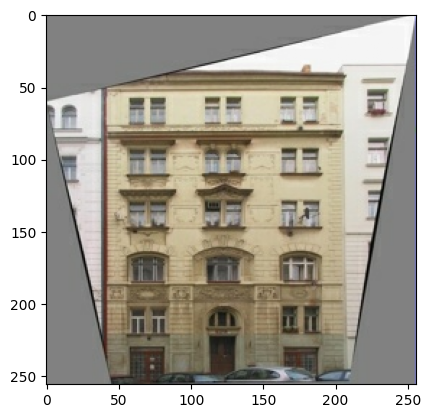

In [362]:
original_img, transformed_img = load_image(str(path / 'train/3.jpg'))
print(original_img.shape, transformed_img.shape)
plt.figure()
plt.imshow(original_img / 255.0)
plt.figure()
plt.imshow(transformed_img / 255.0);

In [363]:
quantity_training = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
quantity_training

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [364]:
quantity_training = len(list(quantity_training))
quantity_training

400

In [365]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [366]:
def resize(original_img, transformed_img, width, height):
  original_img = tf.image.resize(original_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  transformed_img = tf.image.resize(transformed_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return original_img, transformed_img

In [367]:
def normalize(original_img, transformed_img):
  original_img = (original_img / 127.5) - 1
  transformed_img = (transformed_img / 127.5) - 1
  return original_img, transformed_img

In [368]:
def random_crop(original_img, transformed_img):
  stacked_img = tf.stack([original_img, transformed_img], axis = 0)
  crop_img = tf.image.random_crop(stacked_img, size = [2, img_width, img_height, 3])
  return crop_img[0], crop_img[1]

In [369]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.75114655>

In [370]:
@tf.function()
def random_jitter(original_img, transformed_img):
  original_img, transformed_img = resize(original_img, transformed_img, 286, 286)
  original_img, transformed_img = random_crop(original_img, transformed_img)
  if tf.random.uniform(()) > 0.5:
    original_img = tf.image.flip_left_right(original_img)
    transformed_img = tf.image.flip_left_right(transformed_img)
  return original_img, transformed_img

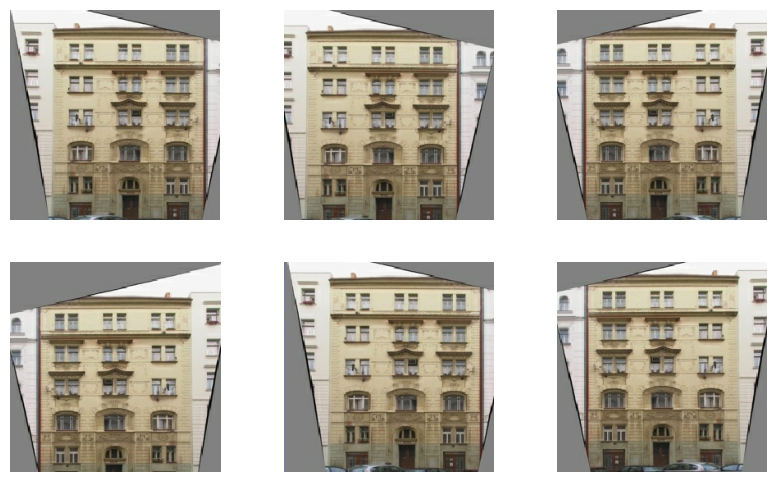

In [371]:
plt.figure(figsize = (10,6))
for i in range(6):
  j_original, j_transformed = random_jitter(original_img, transformed_img)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_transformed / 255.0)
  plt.axis('off')
plt.show()

## Loading the dataset


In [372]:
def load_training_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = random_jitter(original_img, transformed_img)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [373]:
def load_testing_images(img_file):
  
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = resize(original_img, transformed_img, img_width, img_height)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [374]:
training_dataset = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
training_dataset = training_dataset.map(load_training_images, num_parallel_calls=tf.data.AUTOTUNE)
training_dataset = training_dataset.shuffle(buffer_size)
training_dataset = training_dataset.batch(batch_size)

In [375]:
training_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [376]:
try:
  testing_dataset = tf.data.Dataset.list_files(str(path / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  testing_dataset = tf.data.Dataset.list_files(str(path / 'val/*.jpg'))
testing_dataset = testing_dataset.map(load_testing_images)
testing_dataset = testing_dataset.batch(batch_size)

## Generator

The generator is a modified version of [U-Net](https://paperswithcode.com/method/u-net).

U-Net components:
* Encoder (downsampler)
* Decoder (upsampler)

More about U-Net:
* https://paperswithcode.com/method/u-net
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

**Downsample / encode**
 * Convolution -> Batch normalization -> Leaky ReLU

In [377]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                    kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [378]:
original_img.shape

TensorShape([256, 256, 3])

In [379]:
down_model = encode(3, 4)
down_result = down_model(tf.expand_dims(original_img, 0))
print(down_result.shape)

(1, 128, 128, 3)


**Upsample / decode**
 * Transposed convolution -> Batch normalization -> Dropout (applyed for the first 3 blocks) -> ReLU

In [380]:
def decode(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [381]:
up_model = decode(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [382]:
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encode(64, 4, apply_batchnorm = False), # (batch_size, 128, 128, 64)
      encode(128, 4), # (batch_size, 64, 64, 128)
      encode(256, 4), # (batch_size, 32, 32, 256)
      encode(512, 4), # (batch_size, 16, 16, 512)
      encode(512, 4), # (batch_size, 8, 8, 512)
      encode(512, 4), # (batch_size, 4, 4, 512)
      encode(512, 4), # (batch_size, 2, 2, 512)
      encode(512, 4), # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decode(512, 4, apply_dropout=True), # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 8, 8, 512)
      decode(512, 4), # (batch_size, 16, 16, 512)
      decode(256, 4), # (batch_size, 32, 32, 256)
      decode(128, 4), # (batch_size, 64, 64, 128)
      decode(64, 4), # (batch_size, 128, 128, 64)
  ]

  output_channels = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (batch_size, 256, 256, 3)

  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)


In [383]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


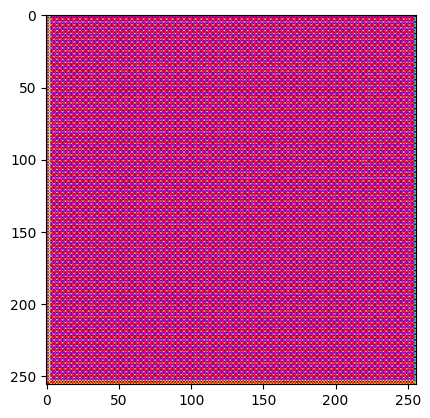

In [384]:
g_output = generator(original_img[tf.newaxis, ...], training=False)
plt.imshow(g_output[0, ...])

### Generator loss

Normal GANs learn loss that adapts to the data, while cGAN learns structured loss that penalizes a possible structure that differs from the network output and the expected "real" image. More details: https://arxiv.org/abs/1611.07004


> **Hyperparameters**

Default values suggested in the paper

* Learning rate: 0.0002
* Momentum: [β1, β2] = [0.5, 0.999]
* Lambda (λ_L1) = 100

* The generator loss is a cross-entropy sigmoid of the generated images and an array of 1's
* The pix2pix paper also mentions L1 loss, which is a MAE (Mean Absolute Error) between the generated image and the expected (real) one. This ensures that the generated image becomes structurally similar to the real image.
* The equation for calculating the total loss is gan_loss + LAMBDA * l1_loss where LAMBDA = 100 - this value is also described by the authors of the paper.

In [385]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [386]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [387]:
def generator_loss(d_generated_output, g_output, target):
  gan_loss = loss(tf.ones_like(d_generated_output), d_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - g_output)) # MAE
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

## Discriminator

The discriminator is a [PatchGAN](https://paperswithcode.com/method/patchgan). The goal is to classify if each patch (piece) of the image is real or fake.

* Blocks of the discriminator: Convolution -> Batch normalization -> Leaky ReLU.

* The output shape is `(batch_size, 30, 30, 1)`

More information: https://arxiv.org/abs/1611.07004

The discriminator receives two inputs:
  1. The input image and the expected image, which should be classified as real
  2. The input image and the generated image (fake, generated by the generator), which should be classified as fake.

In [388]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  original = tf.keras.layers.Input(shape = [256,256,3], name='original_img')
  transformed = tf.keras.layers.Input(shape=[256,256,3], name='transformed_img')
  x = tf.keras.layers.concatenate([original, transformed]) # (batch_size, 256, 256, channels * 2)

  down1 = encode(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down2 = encode(128, 4)(down1) # (batch_size, 64, 64, 128)
  down3 = encode(256, 4)(down2) # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs = [original, transformed], outputs = last)

In [389]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


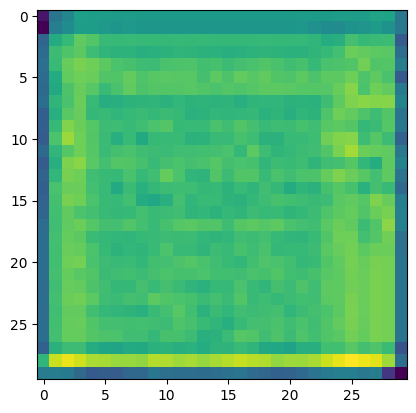

In [390]:
d_output = discriminator([original_img[tf.newaxis, ...], g_output], training=False)
plt.imshow(d_output[0, ..., -1])

### Discriminator loss

It receives two inputs: real images and generated (fake) images
* `real_loss` - sigmoid cross-entropy loss comparing the **real** image and one array of 1's
* `generated_loss (fake)` - sigmoid cross-entropy loss comparing the **generated** image and one array of 0's

The total loss is a sum of both losses

In [391]:
def discriminator_loss(d_real_output, d_generated_output):
  real_loss = loss(tf.ones_like(d_real_output), d_real_output)
  generated_loss = loss(tf.zeros_like(d_generated_output), d_generated_output)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

## Optimizers

In [392]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

## Model checkpoint


In [393]:
checkpoint_dir = './training_checkpoints/{}/'.format(dataset)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Generating images

In [394]:
# def generate_images(model, test_input, real, step = None):
#   generated_img = model(test_input, training=True)
#   plt.figure(figsize=(12,8))

#   img_list = [test_input[0], real[0], generated_img[0]]
#   title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

#   for i in range(3):
#     plt.subplot(1, 3, i + 1)
#     plt.title(title[i])
#     plt.imshow(img_list[i] * 0.5 + 0.5)
#     plt.axis('off')

#   if step is not None:
#     plt.savefig('./results/{}/result_pix2pix_step_{}.png'.format(dataset, step), bbox_inches='tight')

#   plt.show()

In [395]:
# def generate_images(model, test_input, real, step=None):
#     generated_img = model(test_input, training=True)
#     plt.figure(figsize=(12, 8))

#     img_list = [test_input[0], real[0], generated_img[0], real[0] - generated_img[0]]
#     title = ['Input image', 'Real (ground truth)', 'Generated image (fake)', 'Difference']

#     for i in range(4):
#         plt.subplot(1, 4, i + 1)
#         plt.title(title[i])
#         plt.imshow(img_list[i] * 0.5 + 0.5)
#         plt.axis('off')

#     if step is not None:
#         plt.savefig('./results/{}/result_pix2pix_step_{}.png'.format(dataset, step), bbox_inches='tight')

#     plt.show()

# # Iterate through each pair of real and mask images in the testing dataset
# for s, m in testing_dataset.take(5):
#     generate_images(model2, s, m)

In [396]:
# def calculate_difference(model, test_input, real):
#     # Generate an image using the model
#     generated_img = model(test_input, training=True)
    
#     # Calculate the absolute difference between the real and generated images
#     difference = tf.abs(real - generated_img)
    
#     # Compute the average difference across all pixels
#     average_difference = tf.reduce_mean(difference)
    
#     return generated_img, difference, average_difference

# # Iterate through each pair of real and mask images in the testing dataset
# for s, m in testing_dataset.take(5):
#     # Calculate the difference between the real and generated images
#     generated_img, difference, average_difference = calculate_difference(model2, s, m)
    
#     # Visualize the images and differences
#     plt.figure(figsize=(12, 8))

#     img_list = [s[0], m[0], generated_img[0], difference[0]]
#     title = ['Input image', 'Real (ground truth)', 'Generated image (fake)', 'Difference']

#     for i in range(4):
#         plt.subplot(1, 4, i + 1)
#         plt.title(title[i])
#         plt.imshow(img_list[i] * 0.5 + 0.5)
#         plt.axis('off')

#     plt.show()
#     print("Average Difference between Real and Generated Images:", average_difference.numpy())

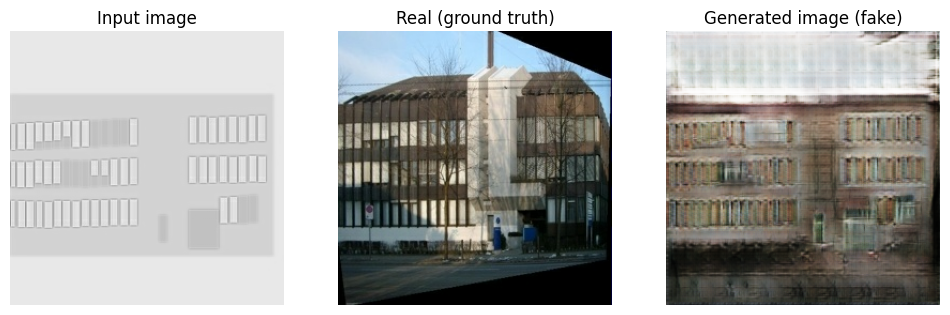

Average Difference between Real and Generated Images: 0.44792688


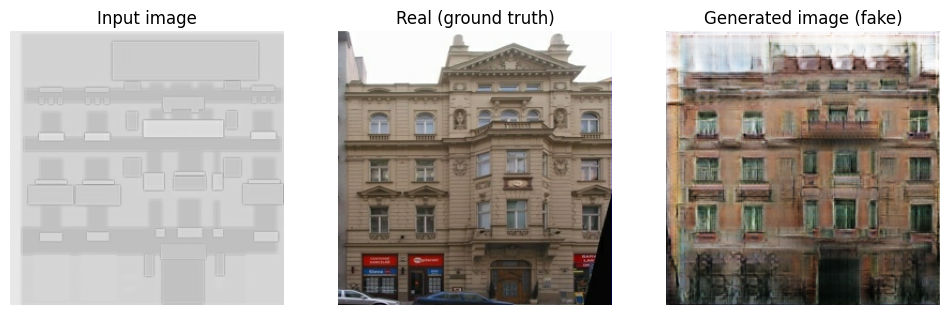

Average Difference between Real and Generated Images: 0.25667945


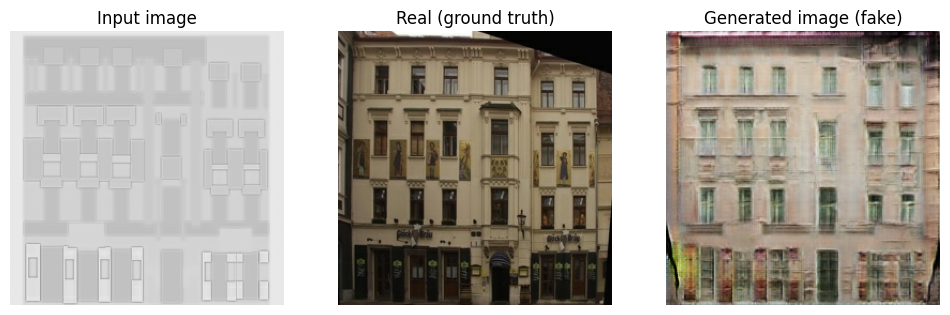

Average Difference between Real and Generated Images: 0.46651682


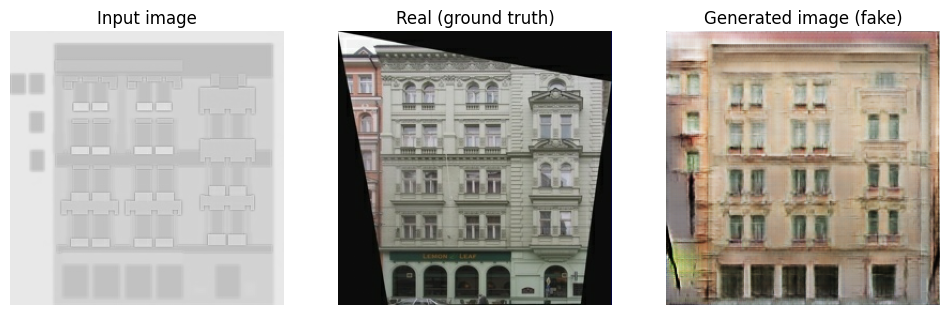

Average Difference between Real and Generated Images: 0.41534007


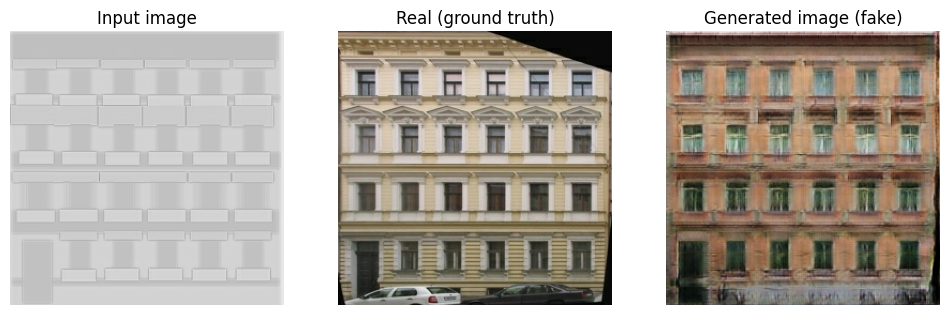

Average Difference between Real and Generated Images: 0.3384583


In [397]:
import matplotlib.pyplot as plt
import tensorflow as tf

def calculate_difference(model, test_input, real):
    # Generate an image using the model
    generated_img = model(test_input, training=True)
    
    # Calculate the absolute difference between the real and generated images
    difference = tf.abs(real - generated_img)
    
    # Compute the average difference across all pixels
    average_difference = tf.reduce_mean(difference)
    
    return generated_img, average_difference

def generate_images(model, test_input, real):
    # Calculate the difference between the real and generated images
    generated_img, average_difference = calculate_difference(model, test_input, real)
    
    # Visualize the input image, the real image, and the generated image
    plt.figure(figsize=(12, 8))

    img_list = [test_input[0], real[0], generated_img[0]]
    title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(img_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()
    print("Average Difference between Real and Generated Images:", average_difference.numpy())

# Call the generate_images function within the loop
for s, m in testing_dataset.take(5):
    generate_images(model2, s, m)


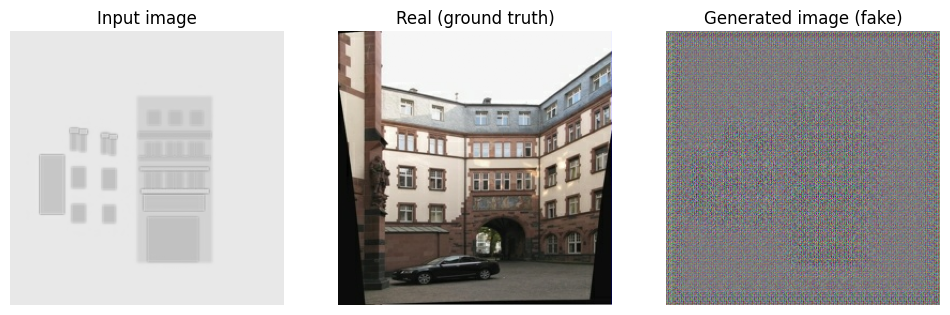

Average Difference between Real and Generated Images: 0.58612084


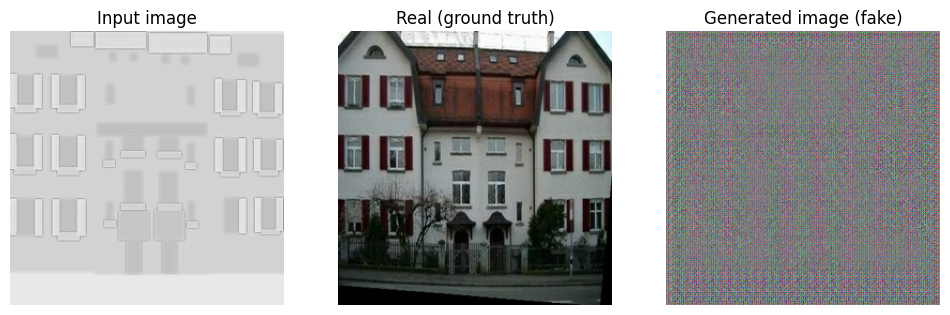

Average Difference between Real and Generated Images: 0.49670973


In [399]:
for input_example, real_example in testing_dataset.take(2):
  generate_images(generator, input_example, real_example)

## Training

* For each input, an output is generated.
* The discriminator receives input_img and the generated images as the first input. The second input is img_entry and the "real" (expected)
* Then, the loss of the generator and discriminator is calculated
* Then we calculate the loss gradients with respect to the generator and discriminator variables (inputs) and apply these to the optimizer.

In [57]:
path_log = 'logs/{}/'.format(dataset)
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [58]:
@tf.function
def training_step(input_img, real, step):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)

    d_output_real = discriminator([input_img, real], training = True)
    d_output_generated = discriminator([input_img, g_output], training = True)

    g_total_loss, g_loss_gan, g_loss_l1 = generator_loss(d_output_generated, g_output, real)
    d_loss = discriminator_loss(d_output_real, d_output_generated)

  generator_gradients = g_tape.gradient(g_total_loss, generator.trainable_variables)
  discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with metrics.as_default():
    tf.summary.scalar('g_total_loss', g_total_loss, step=step//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=step//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=step//1000)
    tf.summary.scalar('d_loss', d_loss, step=step//1000)

In [59]:
def train(training_dataset, testing_dataset, steps):
  test_input, real_input = next(iter(testing_dataset.take(1)))
  start = time.time()

  for step, (input_img, real_img) in training_dataset.repeat().take(steps).enumerate():
    if step % 1000 == 0:
      display.clear_output(wait = True)
      if step != 0:
        print(f'Time taken to run 1000 steps: {time.time() - start:.2f} seconds\n')
      start = time.time()
      generate_images(generator, test_input, real_input, step)
      print(f'Step: {step//1000}K')
    training_step(input_img, real_img, step)
    if (step + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      generator.save_weights('./models/{}/model_pix2pix.h5'.format(dataset))

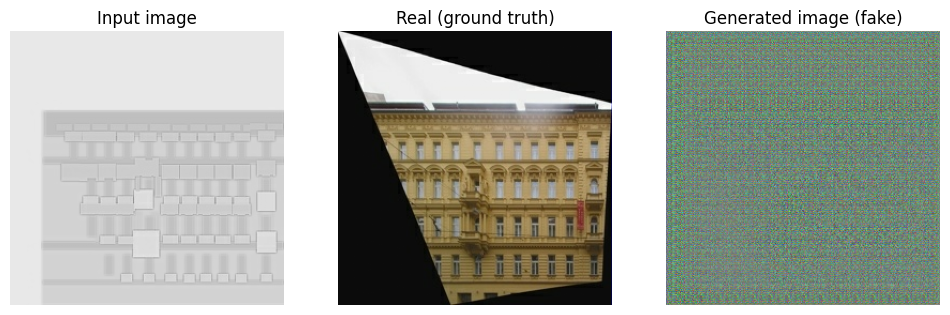

Step: 0K
..............

KeyboardInterrupt: 

In [ ]:
train(training_dataset, testing_dataset, steps = 20000) # 40000

### Comments about training

* Note that neither the generator nor the discriminator "win" over each other. If either the `g_loss_gan` or the `d_loss` are too low, it is an indicator that one is dominating the other, which means that it is not training the two together as it should.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates that the discriminator is generally uncertain about its evaluation (true or false)
* Considering `d_loss`, a value below 0.69 means that the discriminator is doing better than a random classification on the combined set of real and generated images.
* Considering `g_loss_gan`, a value below 0.69 means that the trained generator is fooling the discriminator better than if it were just random generation
* During training, `g_loss_l1` should decrease.

## Checkpoint restauration

In [50]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/facades_b_w/ckpt-5'

In [51]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

OpError: NewRandomAccessFile failed to Create/Open: ./training_checkpoints/facades_b_w/ckpt-5.data-00000-of-00001 : The system cannot find the file specified.
; No such file or directory

## Testing

In [400]:
model2 = Generator()
model2.load_weights('./models/{}/model_pix2pix.h5'.format(dataset))

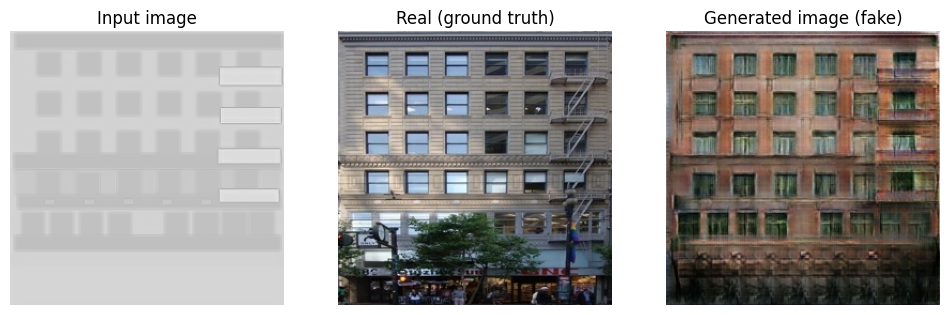

Average Difference between Real and Generated Images: 0.3548807


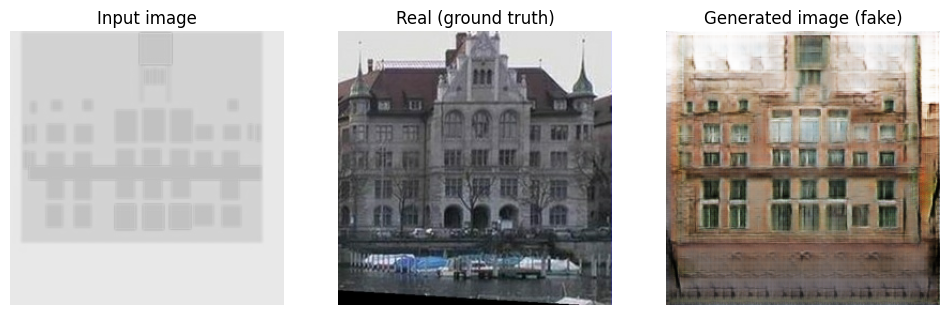

Average Difference between Real and Generated Images: 0.33274588


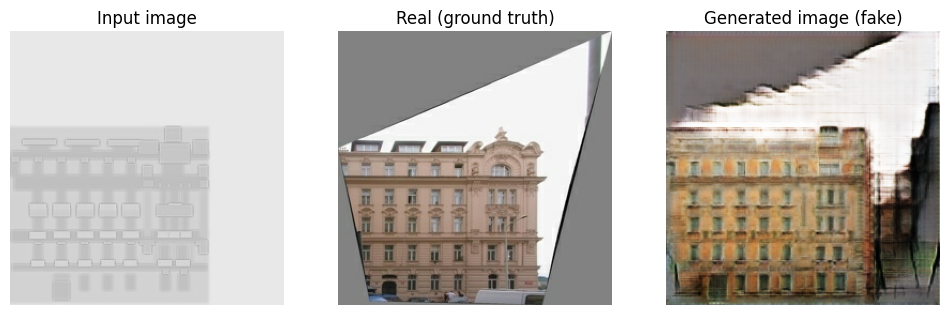

Average Difference between Real and Generated Images: 0.30846915


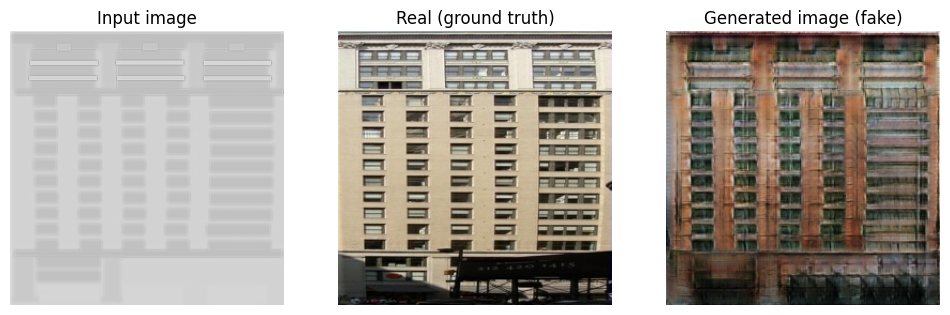

Average Difference between Real and Generated Images: 0.48582745


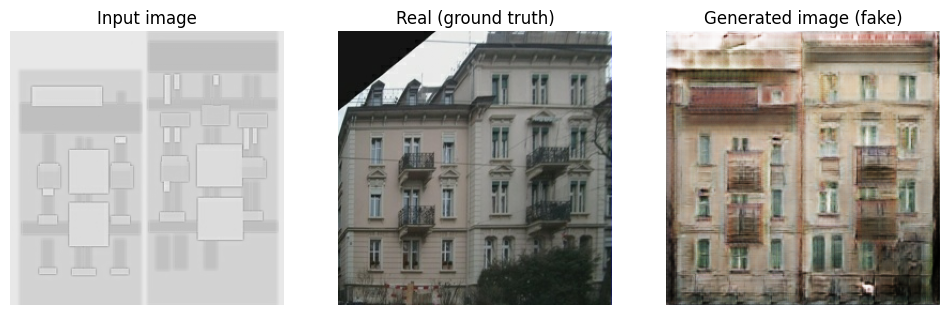

Average Difference between Real and Generated Images: 0.3776568


In [350]:
for s, m in testing_dataset.take(5):
  generate_images(model2, s, m)

# Random testing

In [56]:
path = './datasets/random/facades/img2.jpg'
original_img, transformed_img = load_testing_images(path)

original_img = tf.expand_dims(original_img, axis=0)
transformed_img = tf.expand_dims(transformed_img, axis=0)


# generate_images(model2, original_img, transformed_img)

generate_image = model2(original_img, training=True)

plt.imshow(generate_image[0] * 0.5 + 0.5)
plt.show()

plt.imshow(original_img[0] * 0.5 + 0.5)
plt.show()

# plt.imshow(generate_image[i] * 0.5 + 0.5)
# plt.axis('off')

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: ./datasets/random/facades/img2.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]

Implemetations used for reference:
* https://github.com/affinelayer/pix2pix-tensorflow/blob/master/pix2pix.py
* https://www.tensorflow.org/tutorials/generative/pix2pix
